<img src="https://github.com/superannotateai/automation-suites/blob/main/docs/sa_logo.png?raw=1" width="250" align="left">

#  ASR with Whisper

This tutorial walks you through the ```Automatic Speech Recognition``` automation pipeline within SuperAnnotate platform. 

In this tutorial we will go through the following steps:

1. Setup the environment and install dependences
2. Run the ```OpenAI Whisper``` model on ```US Election 2020 - Presidential Debates``` dataset
3. Setup a ```Video``` project at SuperAnnotate with the dataset audio files (currently audio files are treated basically as videos without visual content, so they are hosted in the ```Video``` editor, we will release a separate ```Audio``` editor very soon, so stay tuned!!!
4. Upload the transcribed text with Whisper as events with start and end time  and corresponding chunk of text to SuperAnnotate platform
5. Results visualized in the platform



# 1.  Environment Setup

Please hit the ```RESTART RUNTIME``` button in the installation logs below, or if it is not there manually navigate Runtime -> Restart Runtime

In [ ]:
! pip install superannotate #SA SDK installation
! pip install git+https://github.com/openai/whisper.git #install OpenAI Whisper

## 1.1  User Variables Setup

SuperAnnotate Python SDK functions work within the team scope of the platform, so a team-level authorization is required. To authorize the package in a given team scope, get the authorization token from the team settings page.

In [ ]:
SDK_TOKEN = "ADD_YOUR_TOKEN_HERE" #Your SuperAnnotate SDK token
PROJECT_NAME = "ADD_YOUR_PROJECT_NAME_HERE" #A project with this name will be created to upload all voice files and transcribtions

## 1.2 Constants Setup

In [ ]:
S3_BASE_URL = "https://sa-public-datasets.s3.amazonaws.com/audio-datasets/us-elections-2020-debates/"
DATASET_FILES = [
    "us_election_2020_1st_presidential_debate.mp3",
    "us_election_2020_2nd_presidential_debate.mp3"
]

## 1.3 Download the data

In [ ]:
from os.path import join
import requests
import os

os.makedirs('data', exist_ok=True)
for dataset_file in DATASET_FILES:
  response = requests.get(join(S3_BASE_URL, dataset_file))
  with open(join('data', dataset_file), 'wb') as f:
    f.write(response.content)

# 2. Model Prediction

In [ ]:
import whisper
from tqdm import tqdm
model = whisper.load_model('tiny')
transcribtions = {}
for dataset_file in tqdm(DATASET_FILES):
  result = model.transcribe(join('data', dataset_file))
  transcribtions[dataset_file] = result["segments"]

# 3. Project Setup

## 3.1 Authorize SA SDK


In [ ]:
from superannotate import SAClient

sa_client = SAClient(token=SDK_TOKEN)

## 3.2 Create the project and attach the dataset

### 3.2.1 Create a Video project

In [ ]:
sa_client.create_project(PROJECT_NAME, "2020 US presidential elections debates' audio transcription with OpenAI Whisper", "Video")

### 3.2.2 Create dataset CSV to attach to the platform

In [ ]:
import pandas as pd

data = {
    "name": DATASET_FILES,
    "url": [join(S3_BASE_URL, dataset_file) for dataset_file in DATASET_FILES]
}
df = pd.DataFrame(data)
df.to_csv('data.csv')

### 3.2.3 Attach the dataset

In [ ]:
sa_client.attach_items(PROJECT_NAME, "./data.csv")

### 3.2.4 Create transcription class with content attribute

In [ ]:
attributes = [{
    'group_type': 'text',
    'name': 'Content'
}]
sa_client.create_annotation_class(project=PROJECT_NAME, name='transcription', color='#FF0000', attribute_groups=attributes, class_type='object')

# 4. Import Predictions

## 4.1 Construct the annotation dictionaries

Having all the transcriptions ready, we proceed to constructing the pre-annotation dictionaries in SA format, which is described in detail [here](https://doc.superannotate.com/docs/import-video-json). In this tutorial we will use only the Event object.

In [ ]:
annotations = []
for file_name, transcription in transcribtions.items():
  sa_format = {
      "metadata": {
          "name": file_name
      },
      "instances": [],
      "tags": [],
      "comments": []
  }
  for transcription_item in transcription:
    start, end = int(transcription_item['start'] * 1000000), int(transcription_item['end'] * 1000000)   #superannote stores start and end times in microseconds
    instance = {
        'meta': {
            'type': 'event',
            'className': 'transcription',
            'start': start, # we put here the start time of the speech event
            'end': end      # we put here the end time of the speech event
        },
        'parameters': [
            {
              'start': start,
              'end': end,
              'timestamps': [ # for the event to be displayed during the whole event duration, we have to append the same attributes object with transcription text twice with start and end times
                  {
                    'timestamp': start,
                    'attributes': [{
                        'groupName': 'Content',
                        'name': transcription_item['text']
                    }]
                  },
                  {
                    'timestamp': end,
                    'attributes': [{
                        'groupName': 'Content',
                        'name': transcription_item['text']
                    }]
                  }
              ]
            }
        ]
    }
    sa_format['instances'].append(instance)
  annotations.append(sa_format)

## 4.2 Upload the transcribtions to the platform

In [ ]:
sa_client.upload_annotations(PROJECT_NAME, annotations)

# 5. Locating the results in the platform

After finishing all these steps you can navigate to the [SuperAnnotate Platform](https://app.superannotate.com), login choose your team (to which the SDK_TOKEN in this tutorial belongs). There a new project with PROJECT_NAME should be created. When opening any of the audio files in that project you will see the editor display as seen below:
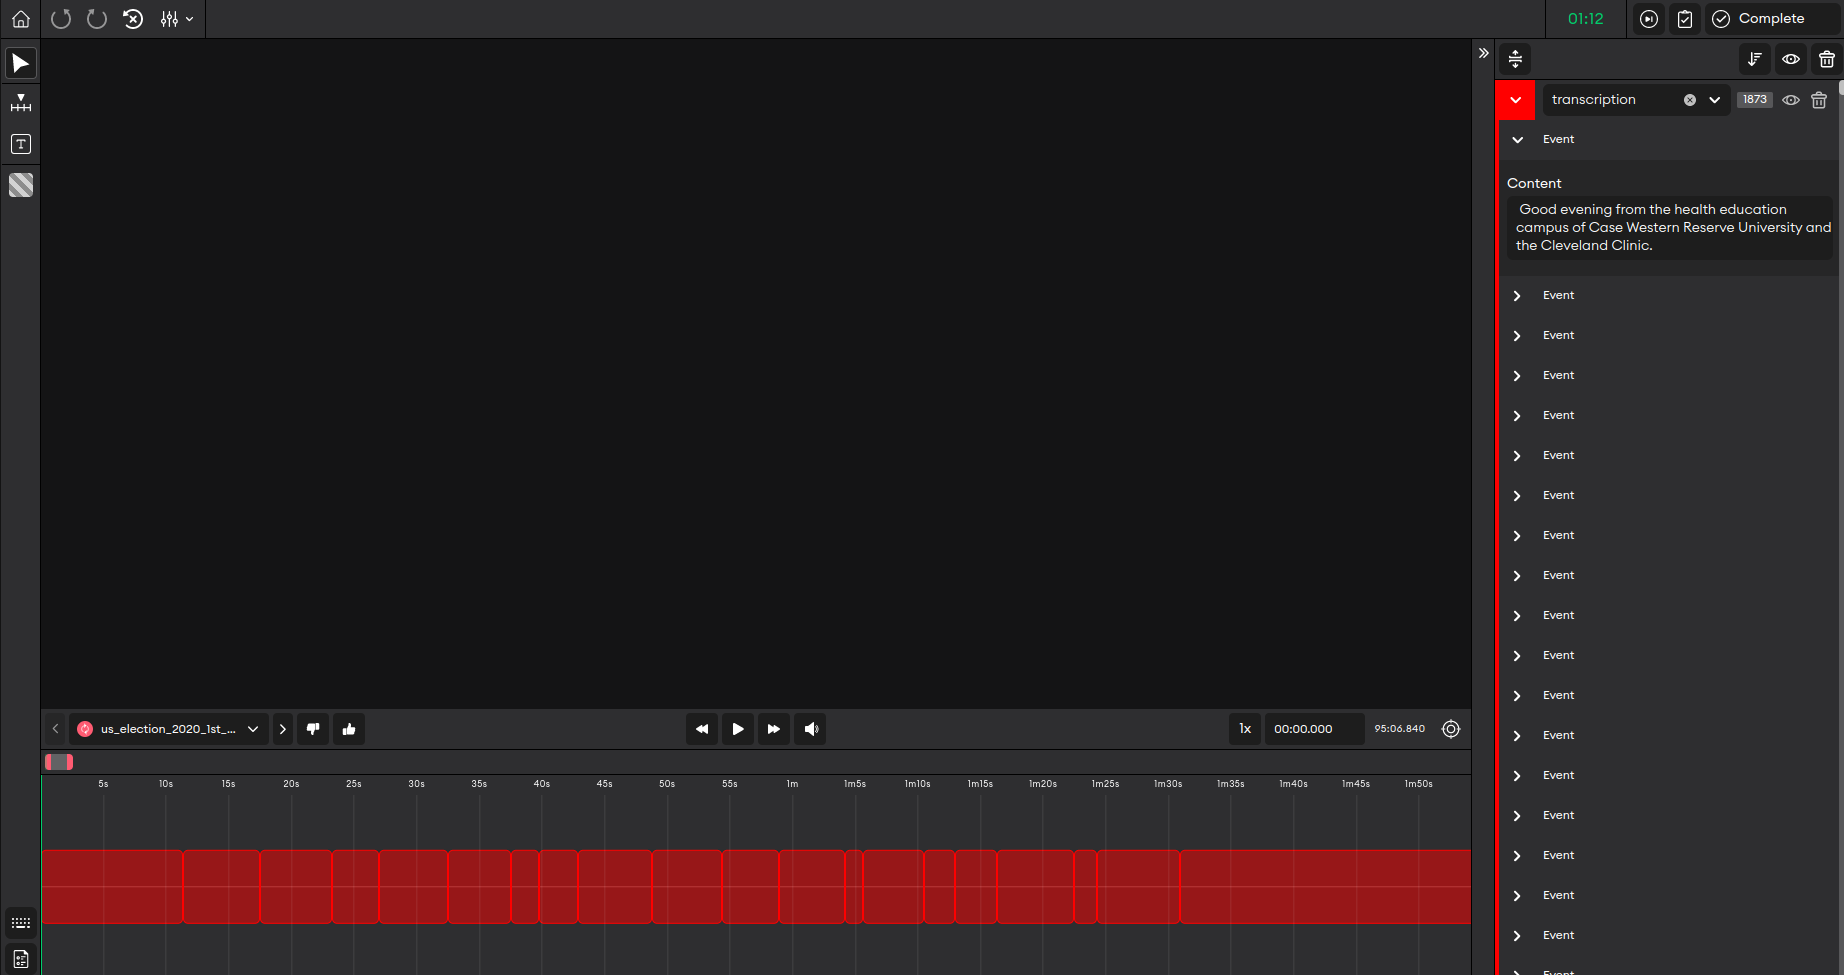
On the right panel you can see all the speech events with corresponding text chunks put ander the ```Content``` attribute. Here's the zoom-in to that panel, where you can clearly see the text of the event's transcription:
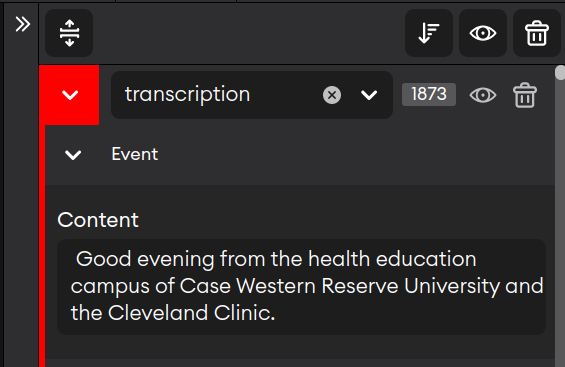